In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample


In [2]:
# Real learning starts here 
df = pd.read_csv("tmp/rnb_features_labeled.csv")

# Separate features and labels
X = df.drop(columns=['recordingmbid', 'is_rnb'])
y = df['is_rnb']

In [3]:
# standarize features for GMM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# Split with stratification to maintain class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=38, stratify=y)

# Separate by class
X_rnb = X_train[y_train == 1]
X_nonrnb = X_train[y_train == 0]

# Downsample Not RnB to match RnB size
X_nonrnb_downsampled = resample(
    X_nonrnb,
    replace=False,              # sampling without replacement
    n_samples=len(X_rnb),       # match RnB size
    random_state=42
)

X_nonrnb =X_nonrnb_downsampled

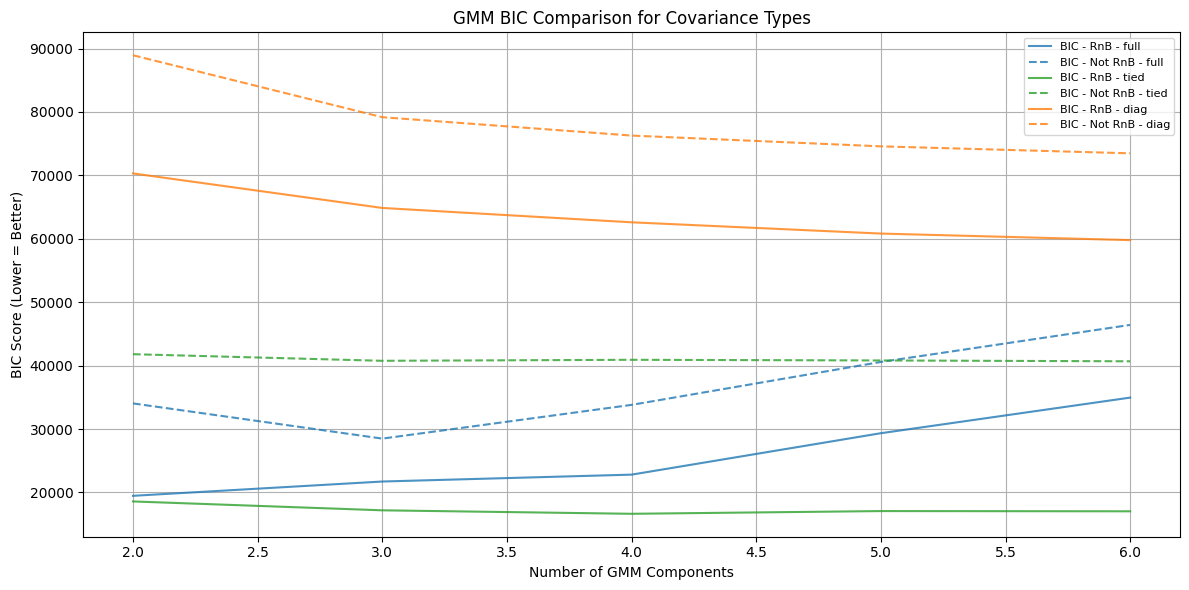

In [19]:
n_range = range(2, 7)
covariance_types = ['full', 'tied', 'diag']

results = {
    'RnB': {cov: {'bic': [], 'aic': []} for cov in covariance_types},
    'Not RnB': {cov: {'bic': [], 'aic': []} for cov in covariance_types}
}

# Loop over covariance types and n_components
for cov_type in covariance_types:
    for n in n_range:
        gmm_rnb = GaussianMixture(n_components=n, covariance_type=cov_type, random_state=42)
        gmm_nonrnb = GaussianMixture(n_components=n, covariance_type=cov_type, random_state=42)

        gmm_rnb.fit(X_rnb)
        gmm_nonrnb.fit(X_nonrnb)

        results['RnB'][cov_type]['bic'].append(gmm_rnb.bic(X_rnb))
        results['Not RnB'][cov_type]['bic'].append(gmm_nonrnb.bic(X_nonrnb))

        results['RnB'][cov_type]['aic'].append(gmm_rnb.aic(X_rnb))
        results['Not RnB'][cov_type]['aic'].append(gmm_nonrnb.aic(X_nonrnb))

# Plotting
plt.figure(figsize=(12, 6))

linestyles = {
    'RnB': '-', 
    'Not RnB': '--'
}
colors = {
    'full': 'tab:blue',
    'diag': 'tab:orange',
    'tied': 'tab:green',
}

for cov in covariance_types:
    for cls in ['RnB', 'Not RnB']:
        plt.plot(n_range, results[cls][cov]['bic'],
                 label=f"BIC - {cls} - {cov}",
                 linestyle=linestyles[cls],
                 color=colors[cov],
                 alpha=0.8)

plt.xlabel("Number of GMM Components")
plt.ylabel("BIC Score (Lower = Better)")
plt.title("GMM BIC Comparison for Covariance Types")
plt.legend(loc='upper right', fontsize=8) 
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Train class-conditional GMMs
gmm_rnb = GaussianMixture(n_components=4, covariance_type='tied', random_state=42)
gmm_nonrnb = GaussianMixture(n_components=3, covariance_type='full', random_state=42)

# trained two models 
gmm_rnb.fit(X_rnb)
gmm_nonrnb.fit(X_nonrnb)

GaussianMixture(n_components=3, random_state=42)

✅ Best F1-score: 0.0634 at threshold: 4.18


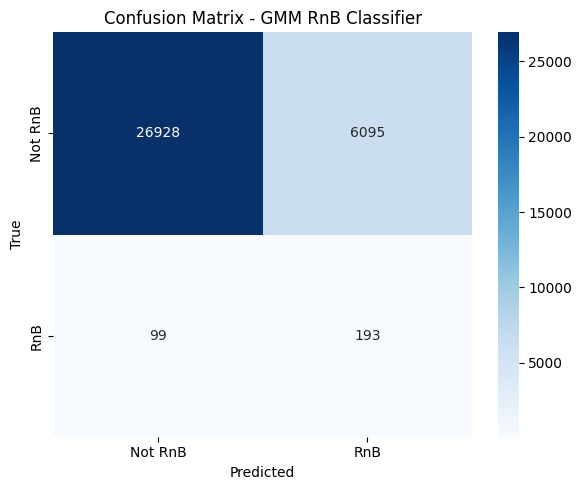


Classification Report:
              precision    recall  f1-score   support

     Not RnB       1.00      0.82      0.90     33023
         RnB       0.03      0.66      0.06       292

    accuracy                           0.81     33315
   macro avg       0.51      0.74      0.48     33315
weighted avg       0.99      0.81      0.89     33315



In [7]:
diff = gmm_rnb.score_samples(X_test) - gmm_nonrnb.score_samples(X_test)

thresholds = np.linspace(-50, 50, 300)
f1_scores = [f1_score(y_test, (diff > t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1_scores)]
print(f"✅ Best F1-score: {max(f1_scores):.4f} at threshold: {best_t:.2f}")

y_pred = (diff> 0 ).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["Not RnB", "RnB"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix - GMM RnB Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not RnB", "RnB"]))

✅ Best F1-score: 0.0636 at threshold: -0.50


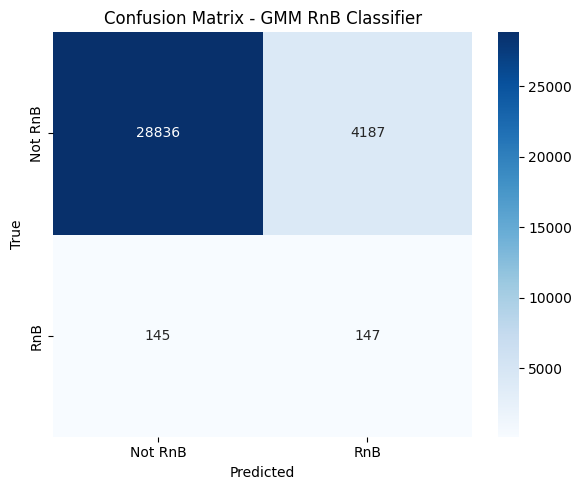


Classification Report:
              precision    recall  f1-score   support

     Not RnB       0.99      0.87      0.93     33023
         RnB       0.03      0.50      0.06       292

    accuracy                           0.87     33315
   macro avg       0.51      0.69      0.50     33315
weighted avg       0.99      0.87      0.92     33315


RnB-Only Metrics:
  Precision (RnB): 0.0339
  Recall (RnB):    0.5034
  F1 Score (RnB):  0.0636


In [8]:
prior_rnb = np.mean(y_train == 1)
prior_non = np.mean(y_train == 0)

# Adjusted log-likelihood difference with priors
log_diff = (
    gmm_rnb.score_samples(X_test) + np.log(prior_rnb)
    - gmm_nonrnb.score_samples(X_test) - np.log(prior_non)
)

thresholds = np.linspace(-50, 50, 300)
f1_scores = [f1_score(y_test, (log_diff > t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1_scores)]
print(f"✅ Best F1-score: {max(f1_scores):.4f} at threshold: {best_t:.2f}")

# Predict with best threshold
y_pred = (log_diff > best_t).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["Not RnB", "RnB"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix - GMM RnB Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not RnB", "RnB"]))

# RnB-specific scores
f1_rnb = f1_score(y_test, y_pred, pos_label=1)
precision_rnb = precision_score(y_test, y_pred, pos_label=1)
recall_rnb = recall_score(y_test, y_pred, pos_label=1)

print(f"\nRnB-Only Metrics:")
print(f"  Precision (RnB): {precision_rnb:.4f}")
print(f"  Recall (RnB):    {recall_rnb:.4f}")
print(f"  F1 Score (RnB):  {f1_rnb:.4f}")

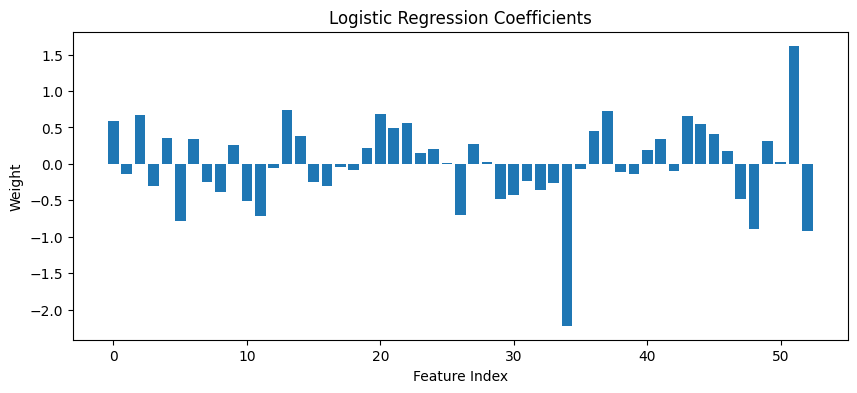

Top Features:
spectral_complexity: -2.2192
spectral_entropy: 1.6211
spectral_strongpeak: -0.9140
spectral_energyband_high: -0.8934
mfcc_5: -0.7880
gfcc_0: 0.7392
zerocrossingrate: 0.7310
mfcc_11: -0.7114
hfc: -0.6979
gfcc_7: 0.6829

Lowest Features:
gfcc_12: 0.0063
key_scale: 0.0264
key_strength: 0.0331
gfcc_4: -0.0439
mfcc_12: -0.0502
spectral_rolloff: -0.0646
gfcc_5: -0.0784
spectral_contrast_4: -0.0927
spectral_contrast_0: -0.1084
spectral_contrast_1: -0.1377


In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_scaled, y)
coefs = clf.coef_[0]

# Plot
plt.figure(figsize=(10, 4))
plt.bar(range(len(coefs)), coefs)
plt.title("Logistic Regression Coefficients")
plt.xlabel("Feature Index")
plt.ylabel("Weight")
plt.show()

# Identify top features based on absolute coefficient values
top_features_idx = np.argsort(np.abs(coefs))[-10:][::-1]
top_features = [X.columns[i] for i in top_features_idx]
top_coefs = coefs[top_features_idx]

# Print top features and their coefficients
print("Top Features:")
for feature, coef in zip(top_features, top_coefs):
    print(f"{feature}: {coef:.4f}")


# Identify lowest features based on absolute coefficient values
lowest_features_idx = np.argsort(np.abs(coefs))[:10]
lowest_features = [X.columns[i] for i in lowest_features_idx]
lowest_coefs = coefs[lowest_features_idx]

# Print lowest features and their coefficients
print("\nLowest Features:")
for feature, coef in zip(lowest_features, lowest_coefs):
    print(f"{feature}: {coef:.4f}")

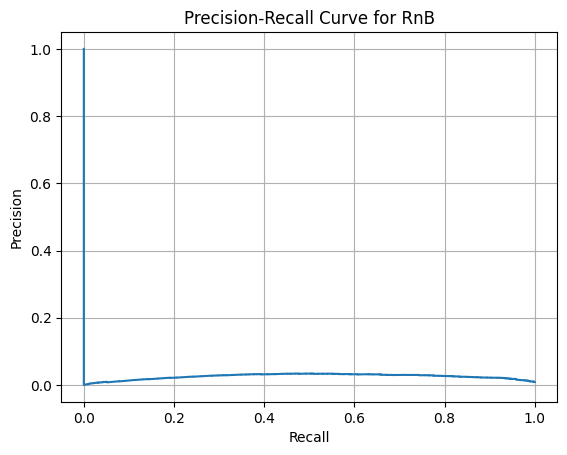

In [10]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, log_diff)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for RnB")
plt.grid(True)
plt.show()

In [11]:
X_train_ll = np.column_stack([
    gmm_nonrnb.score_samples(X_train),
    gmm_rnb.score_samples(X_train)
])
X_test_ll = np.column_stack([
    gmm_nonrnb.score_samples(X_test),
     gmm_rnb.score_samples(X_test)
])

# Extra features based on log-likelihood differences and ratios
log_diff_train = X_train_ll[:, 0] - X_train_ll[:, 1]
log_diff_test = X_test_ll[:, 0] - X_test_ll[:, 1]

log_ratio_train = np.log((np.exp(X_train_ll[:, 0]) + 1e-9) / (np.exp(X_train_ll[:, 1]) + 1e-9))
log_ratio_test = np.log((np.exp(X_test_ll[:, 0]) + 1e-9) / (np.exp(X_test_ll[:, 1]) + 1e-9))

# Concatenate to form enhanced feature vectors
X_train_fused = np.column_stack([X_train_ll, log_diff_train, log_ratio_train])
X_test_fused = np.column_stack([X_test_ll, log_diff_test, log_ratio_test])

In [12]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced', random_state=42)
clf.fit(X_train_fused, y_train)

y_scores = clf.predict_proba(X_test_fused)[:, 1]  # Probability of RnB class

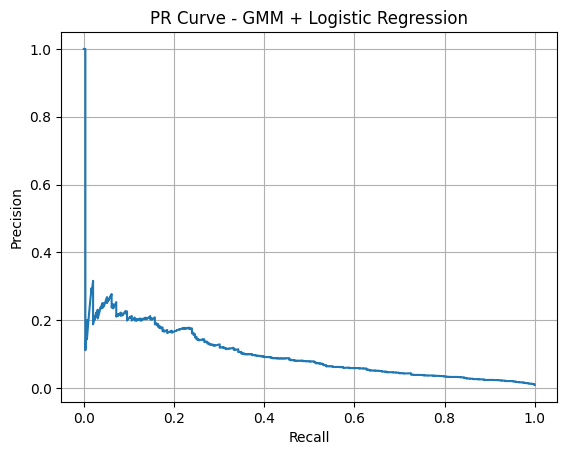

In [13]:
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - GMM + Logistic Regression")
plt.grid(True)
plt.show()

In [14]:
thresholds = np.linspace(0, 1, 500)
f1_scores = [f1_score(y_test, (y_scores > t).astype(int), pos_label=1) for t in thresholds]
best_t = thresholds[np.argmax(f1_scores)]

print(f"Best F1: {max(f1_scores):.4f} at threshold: {best_t:.2f}")

best_t = 0.85

y_pred = (y_scores > best_t).astype(int)

print("Precision (RnB):", precision_score(y_test, y_pred, pos_label=1))
print("Recall (RnB):", recall_score(y_test, y_pred, pos_label=1))
print("F1 Score (RnB):", f1_score(y_test, y_pred, pos_label=1))

Best F1: 0.2012 at threshold: 0.95
Precision (RnB): 0.0911214953271028
Recall (RnB): 0.4006849315068493
F1 Score (RnB): 0.1484771573604061


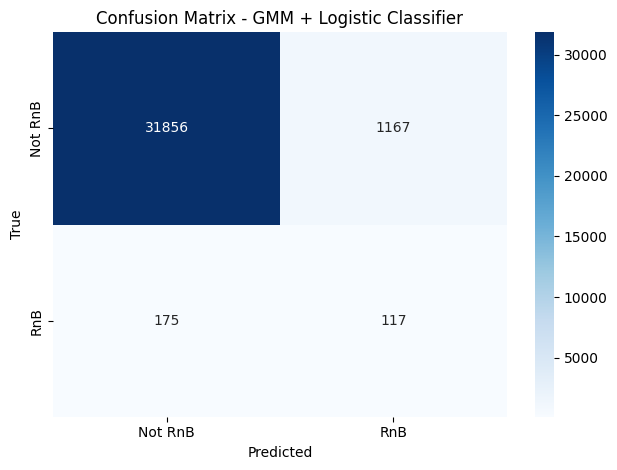

              precision    recall  f1-score   support

     Not RnB       0.99      0.96      0.98     33023
         RnB       0.09      0.40      0.15       292

    accuracy                           0.96     33315
   macro avg       0.54      0.68      0.56     33315
weighted avg       0.99      0.96      0.97     33315



In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not RnB", "RnB"], yticklabels=["Not RnB", "RnB"])
plt.title("Confusion Matrix - GMM + Logistic Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred, target_names=["Not RnB", "RnB"]))


In [16]:
import joblib

# Save GMMs
joblib.dump(gmm_rnb, "GMM_data/model_gmm_rnb.joblib")
joblib.dump(gmm_nonrnb, "GMM_data/model_gmm_nonrnb.joblib")

# Save logistic classifier
joblib.dump(clf, "GMM_data/model_logistic_rnb.joblib")

# Optionally save the StandardScaler and threshold
joblib.dump(scaler, "GMM_data/scaler.joblib")
joblib.dump(best_t, "GMM_data/optimal_threshold.joblib")  # if you're using a tuned threshold

['GMM_data/optimal_threshold.joblib']

In [17]:
# how to load them later
gmm_rnb = joblib.load("GMM_data/model_gmm_rnb.joblib")
gmm_nonrnb = joblib.load("GMM_data/model_gmm_nonrnb.joblib")
clf = joblib.load("GMM_data/model_logistic_rnb.joblib")
scaler = joblib.load("GMM_data/scaler.joblib")
best_t = joblib.load("GMM_data/optimal_threshold.joblib")